In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import find_peaks, butter, lfilter
from scipy.signal import butter, lfilter
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, TransformerMixin

In [46]:
## Function that automatically detects the signal's sample rate
def detect_sample_rate(signal):
    start_time = 2
    time_window = 1
    segment = signal[(signal['time'] >= start_time) & (signal['time'] < start_time + time_window)]
    return len(segment)



## To-do comment
## Function that automatically detects the signal's sample rate
def detect_sample_rate(signal):
    start_time = 2
    time_window = 1
    segment = signal[(signal['time'] >= start_time) & (signal['time'] < start_time + time_window)]
    return len(segment)

## To-do comment
def butter_bandpass(lowcut, highcut, fs, order=5):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype='band')
    return b, a


def butter_bandpass_filter(data, lowcut, highcut, fs, order=5):
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    y = lfilter(b, a, data)
    return y



## Uma classe que implementa o método de filtragem (para usar no pipeline)
## A class that implements the filter method (for pipeline usage).

class Filter(BaseEstimator, TransformerMixin):
    def __init__(self, sample_rate, low_cut, high_cut, order = 5):
        self.sample_rate = sample_rate
        self.low_cut = low_cut
        self.high_cut = high_cut
        self.order = order
        
        
    def fit(self, X, y=None):
        return self
        
    def transform(self, X, y=None):
        self.X = X
        return butter_bandpass_filter(self.X, self.low_cut, self.high_cut, self.sample_rate, self.order)


    
## Uma classe que implementa a extração de segmentos (para usar no pipeline)
## A class that impelments the feature extraction of segments (for pipeline usage)

    
class FeatureExtractor(BaseEstimator, TransformerMixin):
    def __init__(self, number_of_segments, sample_rate):
        self.number_of_segments = number_of_segments
        self.sample_rate = sample_rate
        
        
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        self.X = X
        return self.segmentate()
        

        
    def random_segment_generator(self): 
        window = self.sample_rate*2
        # limit for iteration
        cap = len(self.X) - (window)-1
        
        initial_index = np.random.randint(cap)
        # index maior
        final_index = initial_index + window
        # pegar a janela aleatoria
        return np.array(self.X[initial_index:final_index])
        

    def segmentate(self):

        # armazenará as features extraídas
        
        columns_names = ['mean_q', 'mean_r', 'mean_s',
                         'stdev_q', 'stdev_r','stdev_s',
                         'mean_qrs_interval', 'mean_rr_interval',
                         'mean_rq_amplitude'] # peaks number as a feature later?
    
        self.features_df = pd.DataFrame(columns=columns_names)
        
        
        # pega todos os segmentos originais possíveis de se obter com os dados originais
        # e extrai as features de cada segmento desses
        
        # Sample rate indicates how many data points we have for 1second of measeurement. 
        # We want 2 seconds, so we multiply by 2.
        step = self.sample_rate * 2 
        
        # extraindo todos os segmentos possíveis com passo pré definido.
        for time_window in range(step, len(self.X), step):
            segment = self.X[time_window-step:time_window]

            extracted_features = self.extract_features(segment, self.sample_rate)
            
            ## adiciona as features recentemente extraídas ao dataframe final.
            if not (np.any(extracted_features)):
                continue

            self.features_df.loc[len(self.features_df)] = extracted_features            
        

        # 1° caso: já existem segmentos suficiente, basta escolher n segmentos aleatórios.


        if(len(self.features_df) >= self.number_of_segments):
            correct_sized_df = self.features_df.sample(n=self.number_of_segments, random_state=1) 
            print(f"I selected {len(original_sample)} samples")
            return correct_sized_df
        


        original_segments_only = self.features_df.copy()
        
        # 2° caso: Não há segmentos suficientes, necessário gerar segmentos aleatórios
        
        # variáveis de controle para impedir um loop infinito
        max_attempt = 10_000
        current_attempt = 0
        
        
        # gera os segmentos aleatórios, e extrai as features de cada segmento desses
        while(len(self.features_df) < self.number_of_segments):
           
            #checa máximo de iterações
            if(current_attempt >= max_attempt):
                break
            # adiciona um ao contador de iterações
            current_attempt += 1
            
            # gera o segmento aleatóprio aqui
            random_segment = self.random_segment_generator()
            
            # extrai features do segmento aleatório
            extracted_features = np.array(self.extract_features(random_segment, self.sample_rate))

            
            # checa se é nulo
            if not (np.any(extracted_features)):
                continue

            elif( (self.features_df == extracted_features).all(1).any()):
                #print("ELIMINADO POR SER CÓPIA")
                continue
            else:
                # adiciona o segmento aeatório no dataframe final
                self.features_df.loc[len(self.features_df)] = extracted_features
        

        print(f"I generated {len(self.features_df)} samples for training")

        return original_segments_only, self.features_df


    def get_peaks(self, segment, sample_rate):
        #obtém o valor mais alto presente no segmento.
        max_value = np.max(np.array(segment).astype(float)) # renato preguiçoso se tu não ver isso esse comentário vai ficar aqui
                                                                # denegrindo sua imagem
            
        peaks, _ = find_peaks(segment, height=0.6*max_value, distance=sample_rate*0.2)

        if(len(peaks) < 1):
            return []

        if(peaks[-1] + sample_rate*0.040 > len(segment)):
            peaks = np.delete(peaks, [len(peaks)-1])

        if(len(peaks) < 1):
            return []
        if(peaks[0] -sample_rate*0.040 < 0):
            peaks = np.delete(peaks, [0])

        if(len(peaks) < 1):
            return []

        return peaks
        
        
class FeatureExtractor(BaseEstimator, TransformerMixin):
    def __init__(self, number_of_segments, sample_rate):
        self.number_of_segments = number_of_segments
        self.sample_rate = sample_rate
        
        
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        self.X = X
        return self.segmentate()
        

        
    def random_segment_generator(self): 
        window = self.sample_rate*2
        # limit for iteration
        cap = len(self.X) - (window)-1
        
        initial_index = np.random.randint(cap)
        # index maior
        final_index = initial_index + window
        # pegar a janela aleatoria
        return np.array(self.X[initial_index:final_index])
        

    def segmentate(self):

        # armazenará as features extraídas
        
        columns_names = ['mean_q', 'mean_r', 'mean_s', 'mean_p', 'mean_t',
                         'stdev_q', 'stdev_r','stdev_s',
                         'mean_rr_interval', 'mean_rq_amplitude', 'mean_qrs_interval',
                         'mean_qs_distance', 'mean_qt_distance', 'mean_qrs_offset', 'mean_qrs_onset'] # peaks number as a feature later?
    


 



        self.features_df = pd.DataFrame(columns=columns_names)
        
        
        # pega todos os segmentos originais possíveis de se obter com os dados originais
        # e extrai as features de cada segmento desses
        
        # Sample rate indicates how many data points we have for 1second of measeurement. 
        # We want 2 seconds, so we multiply by 2.
        step = self.sample_rate * 2 
        
        # extraindo todos os segmentos possíveis com passo pré definido.
        for time_window in range(step, len(self.X), step):
            segment = self.X[time_window-step:time_window]

            extracted_features = self.extract_features(segment, self.sample_rate)
            
            ## adiciona as features recentemente extraídas ao dataframe final.
            if not (np.any(extracted_features)):
                continue

            #print(len(self.features_df.columns))
            #print(len(extracted_features))

            self.features_df.loc[len(self.features_df)] = extracted_features            
        

        # 1° caso: já existem segmentos suficiente, basta escolher n segmentos aleatórios.


        if(len(self.features_df) >= self.number_of_segments):
            correct_sized_df = self.features_df.sample(n=self.number_of_segments, random_state=1) 
            print(f"I selected {len(original_sample)} samples")
            return correct_sized_df
        


        original_segments_only = self.features_df.copy()
        
        # 2° caso: Não há segmentos suficientes, necessário gerar segmentos aleatórios
        
        # variáveis de controle para impedir um loop infinito
        max_attempt = 10_000
        current_attempt = 0
        
        
        # gera os segmentos aleatórios, e extrai as features de cada segmento desses
        while(len(self.features_df) < self.number_of_segments):
           
            #checa máximo de iterações
            if(current_attempt >= max_attempt):
                break
            # adiciona um ao contador de iterações
            current_attempt += 1
            
            # gera o segmento aleatóprio aqui
            random_segment = self.random_segment_generator()
            
            # extrai features do segmento aleatório
            extracted_features = np.array(self.extract_features(random_segment, self.sample_rate))

            
            # checa se é nulo
            if not (np.any(extracted_features)):
                continue

            elif( (self.features_df == extracted_features).all(1).any()):
                #print("ELIMINADO POR SER CÓPIA")
                continue
            else:
                # adiciona o segmento aeatório no dataframe final
                self.features_df.loc[len(self.features_df)] = extracted_features
        

        print(f"I generated {len(self.features_df)} samples for training")

        return original_segments_only, self.features_df
    

    def get_peaks(self, segment, sample_rate):
        #obtém o valor mais alto presente no segmento.
        max_value = np.max(np.array(segment).astype(float)) # renato preguiçoso se tu não ver isso esse comentário vai ficar aqui
                                                                # denegrindo sua imagem
            
        peaks, _ = find_peaks(segment, height=0.6*max_value, distance=sample_rate*0.2)

        if(len(peaks) < 1):
            return []

        if(peaks[-1] + sample_rate*0.040 > len(segment)):
            peaks = np.delete(peaks, [len(peaks)-1])

        if(len(peaks) < 1):
            return []
        if(peaks[0] -sample_rate*0.040 < 0):
            peaks = np.delete(peaks, [0])

        if(len(peaks) < 1):
            return []

        return peaks
        
    
    
    
    def find_offset(self, feature_x_position, feature_y_value, segment):
        time_window = int(self.sample_rate*0.04) #40ms
        offset_y_value = float('-inf')
        
        
        
        max_walk = feature_x_position + time_window
        if(max_walk > len(segment)):
           max_walk = len(segment)
           
        for x in range(feature_x_position, max_walk):
           candidate = abs(feature_y_value - segment[x]) / abs(feature_x_position - x)
        
           if(candidate > offset_y_value):
               offset_y_value = candidate
               offset_x_position = x
           
        
        return offset_x_position
        

    def extract_local_features(self, peak_x, segment, sample_rate):
        #y - voltage
        #x - time index (depends on sample rate!)
        
        features = {}
        
        #peak_y = segment[peak_x] #gets the peak value
        features['r_y'] = segment[peak_x]
        features['r_x'] = peak_x 
        
        
        
        search_window_size = int(sample_rate*0.5) # 500ms
        #get P_Q(x, y)
        
        #local_peaks_left = [float('-inf'), float('inf')] # [higher_peak,lower_peak]
        local_max = [float('-inf'), 0] # = [higher_value, index]
        local_min = [float('inf'), 0] # = [minimum value, index]
        for x in range(peak_x, (peak_x-search_window_size), -1):
            if (segment[x] > local_max[0]):
                local_max = [segment[x], x]
            
            if (segment[x] < local_min[0]):
                local_min = [segment[x], x]
        
        
        features['q_y'], features['q_x'] = local_min
        
        features['p_y'], features['p_x'] = local_max
        
        
        #local_peaks_left = [float('-inf'), float('inf')] # [higher_peak,lower_peak]
        local_max = [float('-inf'), 0] # = [higher_value, index]
        local_min = [float('inf'), 0] # = [minimum value, index]
        

        max_walk = (peak_x+search_window_size) if (peak_x+search_window_size) < len(segment) else len(segment) 

        for x in range(peak_x, max_walk):
            #print(x)
            if (segment[x] > local_max[0]):
                local_max = [segment[x], x]
            
            if (segment[x] < local_min[0]):
                local_min = [segment[x], x]
                
        
        features['s_y'], features['s_x'] = local_min
        
        features['t_y'], features['t_x'] = local_max
        
            
        time_window = int(sample_rate*0.04) #40ms
        
    
   #     features['qrs_offset_y'] = float('NaN')

        features['qrs_offset_x'] = float('NaN')

        features['qrs_onset_x'] = float('NaN')

        
        features['qrs_offset_y'] = float('-inf')
        max_walk = (features['s_x']+time_window) if (features['s_x']+time_window) < len(segment) else len(segment)
        for x in range(features['s_x'], max_walk):
            value = abs(features['s_y'] - segment[x]) / abs(features['s_x'] - x)
            
            
            if(value > features['qrs_offset_y']):
                if(value not in [float('inf'), float('-inf')]):
                    features['qrs_offset_y'] = segment[x]
                    features['qrs_offset_x'] = x

        
#         print('_________DEBUG:: F_Y', features['qrs_offset_y'])
#         print('_________DEBUG:: F_X', features['qrs_offset_x'])

#         valor = self.find_offset(features['s_x'], features['s_y'], segment)
#         print('_________DEBUG:: NEW_FUNCTION', valor, segment[valor])

        
        features['qrs_onset_y'] = float('-inf')
        for x in range(features['q_x'], (features['q_x']-time_window), -1):
            value = abs(features['q_y'] - segment[x]) / abs(features['q_x'] - x)
            
            if(value > features['qrs_onset_y']):
                if(value not in [float('inf'), float('-inf')]):
                    features['qrs_onset_y'] = segment[x]
                    features['qrs_onset_x'] = x
           
        

                      
            
            
        if(features['qrs_onset_y'] == float('-inf')):
            features['qrs_onset_y'] = float('NaN')

        if(features['qrs_offset_y'] == float('-inf')):
            features['qrs_offset_y'] = float('NaN')
                
                
        features['qrs_interval'] = features['qrs_offset_x'] - features['qrs_onset_x']
        
        features['rq_amplitude'] = abs(segment[peak_x] - features['q_y'])
        
        features['q_t_distance'] = features['t_x'] - features['q_x']
        
        features['q_s_distance'] = features['s_x'] - features['q_x']
        
        return features
        
    def extract_features(self, segment, sample_rate):
        peaks  = self.get_peaks(segment, sample_rate)
        
        if(len(peaks) < 1):
            return np.array([])

        #finding difference between r times
        difference_between_r = np.diff(peaks)
        
        
        for i in range(len(difference_between_r)):
            if difference_between_r[i] < (sample_rate*0.12):
                #dropped due to this article Weighted Conditional Random Fields for Supervised Interpatient Heartbeat Classification
                difference_between_r.pop(i)

        if np.mean(difference_between_r) == np.nan:
            difference_between_r = 0

        #interval in ms corresponding to each dataset's time unit
        mean_rr_interval = np.mean(difference_between_r)*(1000.0/float(sample_rate)) 
        
        features_global = []
        for peak in peaks:
            #print(peak)
            features_local = (self.extract_local_features(peak, segment, sample_rate))
            features_global.append(features_local)
            
        
        # juntando os dicionarios de features em um único só
        final_features = {}
        for key in features_global[0].keys():
            final_features[key] = tuple(diict[key] for diict in features_global)
        
        # obetendo as últimas features restantes
        mean_q, stdev_q = np.nanmean(np.array(final_features['q_y'])), np.nanstd(np.array(final_features['q_y'])) 
        mean_r, stdev_r = np.nanmean(np.array(final_features['r_y'])), np.nanstd(np.array(final_features['r_y']))
        mean_s, stdev_s = np.nanmean(np.array(final_features['s_y'])), np.nanstd(np.array(final_features['s_y']))
        mean_rq_amplitude = np.nanmean(np.array(final_features['rq_amplitude'])) 
        
        mean_qt_distance = np.nanmean(np.array(final_features['q_t_distance']))#, np.nanstd(np.array(final_features['q_t_distance']))
        mean_qs_distance = np.nanmean(np.array(final_features['q_s_distance']))#, np.nanstd(np.array(final_features['q_s_distance']))
        
        
        mean_p, stdev_p = np.nanmean(np.array(final_features['p_y'])), np.nanstd(np.array(final_features['p_y']))
        mean_t, stdev_t = np.nanmean(np.array(final_features['t_y'])), np.nanstd(np.array(final_features['t_y']))
        

        
        mean_qrs_onset = np.nanmean(np.array(final_features['qrs_onset_y']))
        mean_qrs_offset = np.nanmean(np.array(final_features['qrs_offset_y']))



        mean_qrs_interval = np.nanmean(np.array(final_features['qrs_interval']))#, np.nanstd(np.array(final_features['qrs_interval']))
        
    #     for feature_name in ['q', 'r', 's',]
    #     for features in features_global:
            

            
 
        ff = np.array([mean_q, mean_r, mean_s, mean_p, mean_t,
                      stdev_q, stdev_r, stdev_s, 
                      mean_rr_interval, mean_rq_amplitude, mean_qrs_interval,
                      mean_qs_distance, mean_qt_distance, mean_qrs_offset, mean_qrs_onset])     
        
        
        
        return ff
        

In [16]:
import csv
# configure tqdm printing
#%%capture
from tqdm import tqdm_notebook as tqdm
tqdm().pandas()


path = '../../../physiobank_tool/challenge'
number_of_segments = 120
low_cut = 0.1 # specific for this dataset
files = []

with open(path+'/novo_header.txt') as f:
    reader = csv.reader(f)
    for row in reader:
        #print(row)
        files.append(row[0])
print("Read data for the following drivers:\n", files[:10])


Read data for the following drivers:
 ['te03-0024', 'te03-0031', 'te03-0032', 'te03-0037', 'te03-0041', 'te03-0046', 'te03-0050', 'te03-0054', 'te03-0062', 'te03-0076']


In [17]:
def read_file(file_name):
    ''' Read ecg information from a file and saves it to a dataframe  '''
    cols_of_interest = [0,1]
    ecg_data = pd.read_csv(f'{path}/{file_name}.csv', usecols=cols_of_interest)
    # drop useless header
    ecg_data = ecg_data.drop(ecg_data.index[0])
    # name columns
    ecg_data.columns = ['time', 'ECG']
    # cast some columns to float
    ecg_data['time'] = ecg_data['time'].astype(float)
    ecg_data['ECG'] = ecg_data['ECG'].astype(float)
    
    return ecg_data

In [18]:
df = read_file(files[0])
sample_rate = detect_sample_rate(df)
sample_rate

200

In [19]:
#plt.plot(df['ECG'][:1000])
my_filter = Filter(sample_rate, 1, sample_rate/5.0, order=7)
my_filter.fit(df['ECG'])
data = my_filter.transform(df['ECG'])
#print(data)

In [48]:
extractor = FeatureExtractor(2, sample_rate)

extractor.fit_transform(df['ECG'])

/home/renato/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:425: RuntimeWarning: invalid value encountered in double_scalars
/home/renato/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:443: RuntimeWarning: invalid value encountered in double_scalars


KeyError: 38

Text(0, 0, '')

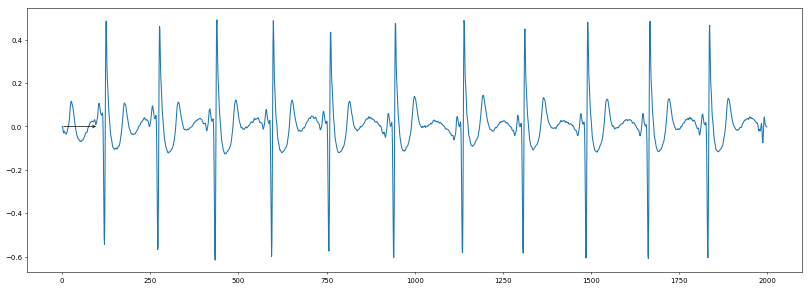

In [22]:
plt.figure(figsize=(20, 7), dpi= 50, facecolor='w', edgecolor='k')
plt.plot(data[:2000])



#plt.plot([(0.2, 200)], marker=11)
plt.annotate("", xy=(100, 0), xytext=(0, 0),
             arrowprops=dict(arrowstyle="->"))


200
16.0


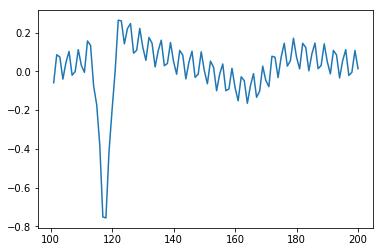

In [8]:


time_window = sample_rate*0.080
print(sample_rate)
print(time_window)
time_window = int(time_window)
df['ECG'][100:200].plot()
#df['ECG'].iloc[200:200+time_window*2].plot()